**Multi-classification** Problem using supervised ML.

*Note: This problem could be also tackled with Regression*

In [225]:
# Data handling
import pandas as pd
import numpy as np
import random
# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm 
from pandas.plotting import scatter_matrix
import seaborn as sns
# Data Split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
# Data Pre-Processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
# Modeling
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
# Tunning
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
# Assesing model performance
from sklearn.metrics import SCORERS
from sklearn import metrics as m
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# Ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [226]:
df = pd.read_csv("winequality-red.csv")

#### 1. Visualize and analyze the data

In [227]:
df.isna().sum() # no nan values ✔

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [228]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000,1596.000000
mean,8.314160,0.527954,0.270276,2.535558,0.087120,15.858396,46.382206,0.996744,3.311917,0.656385,10.421147,5.637218
std,1.732203,0.179176,0.193894,1.405515,0.045251,10.460554,32.839138,0.001888,0.153346,0.163057,1.060371,0.807080
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.860000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996745,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997832,3.400000,0.730000,11.100000,6.000000
max,15.600000,1.580000,0.790000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,1.980000,14.000000,8.000000


In [229]:
df.shape # m=1596, n= 11(potentially)

(1596, 12)

In [230]:
# a mapping dictionary that maps the quality values from 0 to 5
quality_mapping = {
3: 0, 4: 1, 5: 2, 6: 3, 7: 4, 8: 5}
# you can use the map function of pandas with any dictionary 
# to convert the values in a given column to values in the dictionary

df["quality"] = df["quality"].map(quality_mapping)

##### Feature Engineering:
Lets generate some extra-variables based on the available ones

In [231]:
# df["acidity_by_Ph"] = df["fixed acidity"]/df["pH"]
df["density_sugar"] = df["density"]/df["residual sugar"]
df["sulphate_by_chloride"] = df["sulphates"]/df["chlorides"]

In [232]:
df.drop("sulphates", axis=1, inplace=True) # we will incorporate sulphate_by_chloride which correlates better

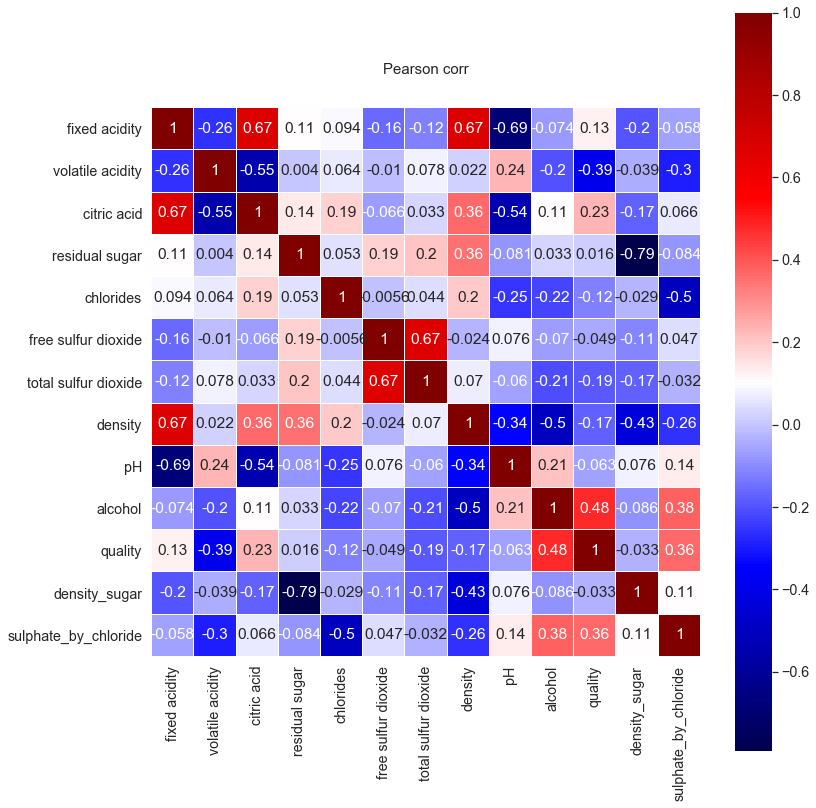

In [233]:
plt.rcParams["figure.figsize"] = (12,12)
colormap=plt.cm.seismic
plt.title("Pearson corr", y=1.05, size=15)
sns.heatmap(df.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor="white", annot=True)
plt.tight_layout()
# plt.savefig("corr.png", dpi=400)
plt.show()

In [234]:
corr_matrix = df.corr()
corr_vals = abs(corr_matrix["quality"]).sort_values(ascending=False)
top8_corr =  corr_vals[1:9]

In [235]:
top8_corr # we will carry with these attributes for the modeling

alcohol                 0.480738
volatile acidity        0.391735
sulphate_by_chloride    0.363317
citric acid             0.233733
total sulfur dioxide    0.185404
density                 0.173251
fixed acidity           0.127766
chlorides               0.119770
Name: quality, dtype: float64

In [236]:
top8_corr = pd.DataFrame(top8_corr)

We observe that the atributes that correlate best with the wine quality are alcohol, volatile acicity, sulphates, citric acid, total sufur dioxide, density, fixed acidity and chlorides. We will be using these in the modeling

Note: To prevent the model from overfitting I decided to remove two attributes which seemed to not have a major importance and correlation with the target (citric acid and fixed acidity)

In [237]:
# top8_corr.drop(["citric acid", "fixed acidity"], axis=0, inplace=True)

In [238]:
list_top8 = list(top8_corr.index)

In [239]:
list_top8.append("quality")

In [240]:
df_model = df[list_top8]

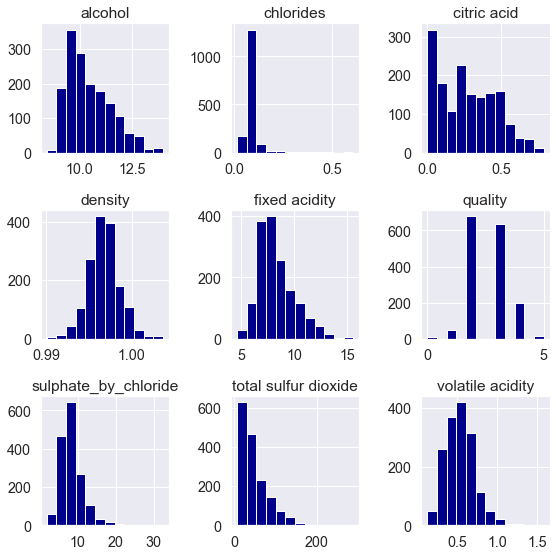

In [241]:
plt.rcParams["figure.figsize"] = (8,8)
df_model.hist(bins=12, color="darkblue")
plt.tight_layout()
# plt.savefig("hist_features.png", dpi=400)
plt.show()


We can see that most of the selected attributes shown an skewed distribution and possess different scales. We will therefore standarized the data before modeling. But first, lets split the data into the test and train sets.

#### 2. Splitting data: 
First we check the distribution of the target values to see if an stratified split is needed

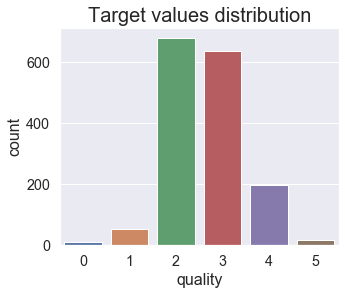

In [242]:
plt.rcParams["figure.figsize"] = (5,4)
ax = sns.countplot(x='quality', data=df)
ax.set_title("Target values distribution", fontsize=20)
ax.set_xlabel("quality", fontsize=16)
ax.set_ylabel("count", fontsize=16)
# plt.savefig("target_values_distribution.png", dpi=400)
plt.show()

We can see that we have a skewed dataset for classification 
so we may want to stratify the data before split. Furthermore, we will want to use **stratified k-fold cross-validation** (For classification problems).

-> There are several choices for selecting the appropriate number of bins. If
you have a lot of samples( > 10k, > 100k), then you don’t need to care about the
number of bins. Just divide the data into 10 or 20 bins. If you do not have a lot of
samples, you can use a simple rule like Sturge’s Rule to calculate the appropriate
number of bins.


Number of Bins = 1 + log2(N) Where N is the number of samples you have in your dataset. # 12 in our case

For the stratification we will use the most correlated attribute (alchohol)

In [243]:
def strater (col_item):
    if col_item <= 9.3:
        return 1
    elif col_item > 9.3 and col_item <= 10:
        return 2
    elif col_item > 10 and col_item <= 11:
        return 3
    elif col_item > 11 and col_item <= 12:
        return 4
    else:
        return 5

In [244]:
df_model["strat"] = df_model["alcohol"].apply(strater)

In [245]:
gist_heat = cm.get_cmap('gist_heat', 200)

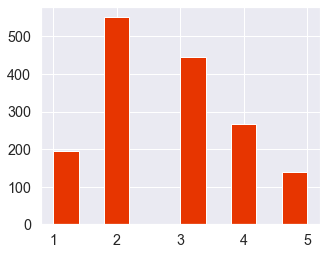

In [246]:
df_model["strat"].hist(color=gist_heat(random.uniform(0, 1)))
plt.show()

In [247]:
split = StratifiedShuffleSplit(n_splits = 1, test_size=0.20, random_state=10)

In [248]:
for train_index, test_index in split.split(df_model, df_model["strat"]):
    strat_train_set = df_model.loc[train_index]
    strat_test_set = df_model.loc[test_index]

In [249]:
# we will also do a random split to compare the results of the distribution
X = df_model.drop("quality", axis=1)
y = df_model["quality"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10) # 0.2 means 80 % is in our train set and 20

In [250]:
def proportions(data):
    return data["strat"].value_counts()/len(data)

In [251]:
comparing = pd.DataFrame({"Overall": proportions(df_model),
                         "Stratified": proportions(strat_test_set),
                         "Random": proportions(X_test)}).sort_index()

In [252]:
comparing = comparing *100 

In [253]:
comparing 
# We can observe how the proportions in the stratified set are closer 
# to those in the whole set compared to the ramdomly generated set

,Overall,Stratified,Random
1,12.155388,12.1875,11.8750
2,34.523810,34.3750,33.4375
3,27.819549,27.8125,27.1875
4,16.729323,16.8750,17.5000
5,8.771930,8.7500,10.0000


In [254]:
df_model.drop("strat", axis=1, inplace=True)

In [255]:
X = df_model.drop("quality", axis=1)

we go with stratified split then:

In [256]:
strat_train_set.drop("strat", axis=1, inplace=True)
strat_test_set.drop("strat", axis=1, inplace=True)

In [257]:
X_train = strat_train_set.drop("quality", axis=1)
y_train = strat_train_set["quality"].values

In [258]:
X_test = strat_test_set.drop("quality", axis=1)
y_test = strat_test_set["quality"].values

#### 3. Standarization of the data
Standardizing the features around the center and 0 with a standard deviation of 1 is important when we compare measurements that have different units.

* Standarize Train set

<!-- Standarization implies that the features will be rescaled to ensure the mean and the standard deviation to be 0 and 1, respectively. -->

In [259]:
scaler = StandardScaler().fit(X_train) # Best results
X_train_rescaled = scaler.transform(X_train)

In [260]:
# from sklearn.preprocessing import MinMaxScaler # did not improve the model
# scaler = MinMaxScaler(feature_range=(0, 1))
# X_train_rescaled = scaler.fit_transform(X_train) # use MinMaxScaler to revert the re-scaled data

In [261]:
# from sklearn.preprocessing import Normalizer # did not improve the model
# scaler = Normalizer().fit(X_train)
# X_train_rescaled = scaler.transform(X_train)

In [262]:
df_rescaled = pd.DataFrame(X_train_rescaled, columns=df_model.columns[:-1])

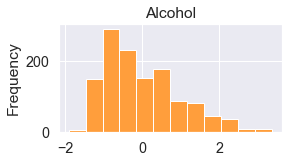

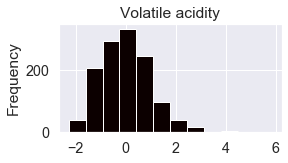

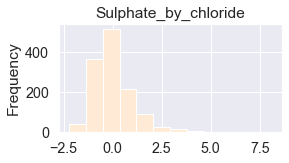

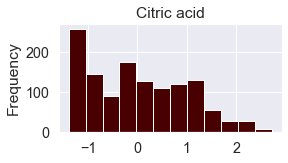

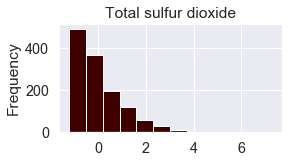

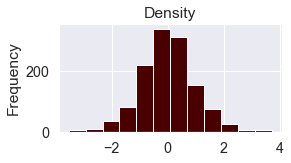

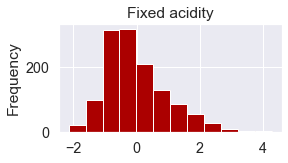

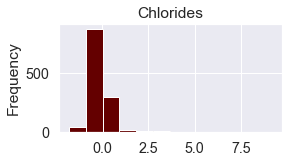

In [263]:

for i in top8_corr.index:
    df_rescaled[i].plot(kind="hist", bins=12,
               figsize=(4,2), 
               title=str.capitalize(i),
               color=gist_heat(random.uniform(0, 1)))
    plt.show()

* Standarize Test set

In [264]:
scaler = StandardScaler().fit(X_test) # Best results with StandardScaler compared to the transformations MinMaxScaler and Normalizer
X_test_rescaled = scaler.transform(X_test)

In [265]:
# scaler = MinMaxScaler(feature_range=(0, 1)) 
# X_test_rescaled = scaler.fit_transform(X_test)

In [266]:
# scaler = Normalizer().fit(X_test)
# X_test_rescaled = scaler.transform(X_test)

#### 4. Exploring model performance

**What performance metric should we use?**  It depends on the purpose of our model but for this case scenario we may want a balanced model with acceptable precision as well as recall. Hence, f1_score may be prefered. Furthermore, since the distribution of our targets is imbalanced, we may want to use micro-averages which aggregates the contributions of all classes to compute the average metric. Macro-average on the other side would treat all classes equally and would be preferred in a balanced class distribution scenario.

In [267]:
SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [268]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('BC_LR', BaggingClassifier(LogisticRegression())))
models.append(('SGD', SGDClassifier())) 
models.append(('GNB', GaussianNB()))
models.append(('KNC', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier())) # Note: When using tree based algos with no regularization, most likely they will overfit
models.append(('AB_CART', AdaBoostClassifier(DecisionTreeClassifier())))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('RFC', RandomForestClassifier())) # n_estimators=100, max_features=6
models.append(('ETC', ExtraTreesClassifier()))
models.append(('SVC', SVC()))
models.append(('BC_SVC', BaggingClassifier(SVC())))
models.append(('XGB', xgb.XGBClassifier()))


results_model = []
names_model = []
for name, model in models:
    SKF = StratifiedKFold(n_splits=12, random_state=10)
    cv_results = cross_val_score(model, X_train_rescaled, y_train, cv=SKF, scoring='f1_micro')
    results_model.append(cv_results)
    names_model.append(name)
    msg = "%s: Score = %f, STD = %f" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: Score = 0.592466, STD = 0.044876
BC_LR: Score = 0.590872, STD = 0.038038
SGD: Score = 0.506921, STD = 0.061689
GNB: Score = 0.542276, STD = 0.037442
KNC: Score = 0.580725, STD = 0.045412
CART: Score = 0.597139, STD = 0.043777
AB_CART: Score = 0.582246, STD = 0.043621
GBC: Score = 0.612862, STD = 0.046847
RFC: Score = 0.676387, STD = 0.039322
ETC: Score = 0.667754, STD = 0.036421
SVC: Score = 0.607366, STD = 0.036009
BC_SVC: Score = 0.612855, STD = 0.034036
XGB: Score = 0.626212, STD = 0.044509


In [269]:
values= []
for i in results_model:
    values.append(round(np.mean(i),3))

In [270]:
zipped = list(zip(names_model, values))

In [271]:
labels = []
for name,value in zipped:
    labels.append("".join((name,("("+str(value)+")"))))
    

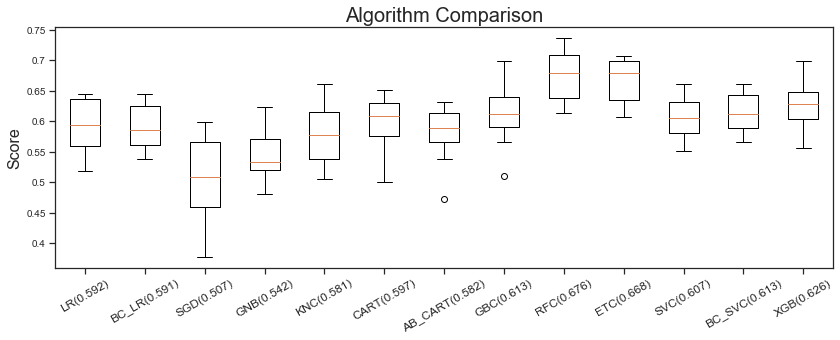

In [272]:
# Compare Algorithms
sns.set_style("ticks")
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
plt.boxplot(results_model)
ax.set_title('Algorithm Comparison', fontsize=20)
plt.ylabel("Score", fontsize=16)
ax.set_xticklabels(labels, rotation=30, fontsize=12)
ax.set_yticklabels([0.35,0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75], fontsize=10)
plt.gcf().subplots_adjust(bottom=0.30)
plt.tight_layout()
# plt.savefig("Algo_comparison.png", dpi=400)
plt.show()


Lets select three best performing models, tune them and ensemble them to achieve a better performing model.

#### 5.1 Fine tune SVC

In [273]:
# Tried different combinations and chose the algo based on the score but also on the values of the hyperparameters to obtain some regularization of the model
# kernel = ["linear", "poly", "rbf", "sigmoid"] 
C = [1.5] # The lower the higher regularization # [0.1, 0.5, 1.5, 2.5, 8.5] 
gamma = [0.2] # The lower the higher regularization
tol = [0, 0.0001, 0.001, 0.1, 0.5, 1]
# degree = [1,3]
kernel = ["rbf"]


param_grid = dict(kernel=kernel, C=C, gamma=gamma, tol=tol)


model = SVC()
SKF = StratifiedKFold(n_splits=12, random_state=10)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="f1_micro", cv=SKF)
grid_result = grid.fit(X_train_rescaled, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    # 0.605801 (0.038748) with: {'C': 1.5, 'gamma': 0.1, 'kernel': 'rbf'}

Best: 0.609718 using {'C': 1.5, 'gamma': 0.2, 'kernel': 'rbf', 'tol': 0.0001}
nan (nan) with: {'C': 1.5, 'gamma': 0.2, 'kernel': 'rbf', 'tol': 0}
0.609718 (0.039916) with: {'C': 1.5, 'gamma': 0.2, 'kernel': 'rbf', 'tol': 0.0001}
0.609718 (0.039916) with: {'C': 1.5, 'gamma': 0.2, 'kernel': 'rbf', 'tol': 0.001}
0.609718 (0.038240) with: {'C': 1.5, 'gamma': 0.2, 'kernel': 'rbf', 'tol': 0.1}
0.605037 (0.044341) with: {'C': 1.5, 'gamma': 0.2, 'kernel': 'rbf', 'tol': 0.5}
0.608953 (0.040853) with: {'C': 1.5, 'gamma': 0.2, 'kernel': 'rbf', 'tol': 1}


In [274]:
SVC_rbf = SVC(kernel="rbf", C=1.5, gamma=0.1, tol=0.001, probability=True)
SVC_rbf.fit(X_train_rescaled, y_train)

SVC(C=1.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

Note: Under the hood Sklearn uses the OvO (One Vs One) strategy for this multi-classification problem, resulting in N × (N – 1) / 2 classifiers -> 15 classifiers in our case. Hence our model trained **15 binary classifiers**, got their decision scores for each case, and selected the class that won the most duels.

#### 5.2 Evaluating SVC

In [275]:
SVC_rbf.score(X_train_rescaled,y_train)

0.658307210031348

In [276]:
SVC_rbf.score(X_test_rescaled,y_test)

0.6125

In [277]:
# Lets predict one single instance from the test set
SVC_rbf.predict_proba(list(X_test_rescaled[0].reshape(1,-1))) # is appears to be class 2, although the probability to be class 3 is fairly high 

array([[0.00462533, 0.03155366, 0.5588174 , 0.35356874, 0.04776479,
        0.00367008]])

In [278]:
SVC_rbf.predict(list(X_test_rescaled[0].reshape(1,-1)))

array([2], dtype=int64)

In [279]:
y_preds = SVC_rbf.predict(X_test_rescaled)
print("=====================\nF1_score:\n")
print(m.f1_score(y_test, y_preds, average='micro'))
print("=====================\nConfusion Matrix:\n")
print(m.confusion_matrix(y_test, y_preds))
print("\n=================\nClassification Report:\n")
print(m.classification_report(y_test, y_preds))

F1_score:

0.6125
Confusion Matrix:

[[  0   0   2   0   0   0]
 [  0   0   4   2   0   0]
 [  0   0 106  41   1   0]
 [  0   0  35  81   9   0]
 [  0   0   1  25   9   0]
 [  0   0   0   3   1   0]]

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         6
           2       0.72      0.72      0.72       148
           3       0.53      0.65      0.58       125
           4       0.45      0.26      0.33        35
           5       0.00      0.00      0.00         4

    accuracy                           0.61       320
   macro avg       0.28      0.27      0.27       320
weighted avg       0.59      0.61      0.60       320



Another important aspect of the model functioning is **feature
importance**. We can use an attibute called coef_ to stimate feature importance in SVC models, but the kernel needs to be linear. Lets train a SVC with kernel linear to get idea about the feature importance in this type of model:

In [280]:
SVC_linear = SVC(kernel="linear", C=1.5)
SVC_linear.fit(X_train_rescaled, y_train)

SVC(C=1.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [281]:
features_dict_SVC = dict(zip(top8_corr.index, list(SVC_linear.coef_[0])))
features_imp_df_SVC = pd.DataFrame(features_dict_SVC, index=["feature_importance"]).T

In [282]:
top8_corr.columns = ["feature_corr"]

In [283]:
features_df_SVC = pd.concat([top8_corr, features_imp_df_SVC], axis=1)

In [284]:
features_df_SVC

,feature_corr,feature_importance
alcohol,0.480738,-0.241646
volatile acidity,0.391735,0.468525
sulphate_by_chloride,0.363317,0.217496
citric acid,0.233733,0.079163
total sulfur dioxide,0.185404,-0.574641
density,0.173251,0.378974
fixed acidity,0.127766,0.042825
chlorides,0.119770,0.701036


In [285]:
# using a colormap
seismic = cm.get_cmap('seismic', 20)

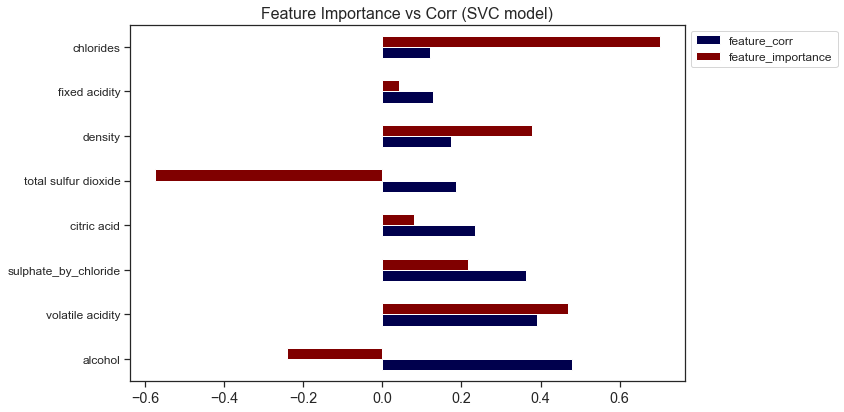

In [286]:
# Visualize feature correlations and importance

features_df_SVC.plot(kind="barh", legend=True, label=True, figsize=(12,6), colormap=seismic)
plt.legend(bbox_to_anchor=(1, 1), fontsize=12)
plt.title("Feature Importance vs Corr (SVC model)", fontsize=16)
plt.yticks(fontsize=12)
plt.tight_layout()
# plt.savefig("importance_vs_corr_SVC.png", dpi=400)

As we can see atributes with highest feature importance are chlorides and total sulfur dioxide. These results show that the features with high correlation with the target actually do not have the highest feature importance.

#### 6.1 Fine tune RFC

In [287]:

max_depth = [8] # The lower the higher regularization 
# n_estimators = [50,100,150]
max_features = [2,4,6] # The lower the higher regularization 
min_samples_leaf = [8] # [2, 6, 12, 20] The higher the higher the regularization

param_grid = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf, max_features=max_features)


model = RandomForestClassifier()
SKF = StratifiedKFold(n_splits=12, random_state=10)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="f1_micro", cv=SKF)
grid_result = grid.fit(X_train_rescaled, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.625367 using {'max_depth': 8, 'max_features': 4, 'min_samples_leaf': 8}
0.623009 (0.040702) with: {'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 8}
0.625367 (0.029028) with: {'max_depth': 8, 'max_features': 4, 'min_samples_leaf': 8}
0.623031 (0.038615) with: {'max_depth': 8, 'max_features': 6, 'min_samples_leaf': 8}


In [288]:
RFC =  RandomForestClassifier(max_depth=3, max_features=4, min_samples_leaf=3)
RFC.fit(X_train_rescaled, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### 6.2 Evaluating RFC

In [289]:
RFC.score(X_train_rescaled,y_train)

0.6214733542319749

In [290]:
RFC.score(X_test_rescaled,y_test)

0.615625

In [291]:
y_preds = RFC.predict(X_test_rescaled)
print("=====================\nF1_score:\n")
print(m.f1_score(y_test, y_preds, average='micro'))
print("=====================\nConfusion Matrix:\n")
print(m.confusion_matrix(y_test, y_preds))
print("\n=================\nClassification Report:\n")
print(m.classification_report(y_test, y_preds))

F1_score:

0.615625
Confusion Matrix:

[[  0   0   1   1   0   0]
 [  0   0   4   2   0   0]
 [  0   0 103  44   1   0]
 [  0   0  38  85   2   0]
 [  0   0   0  26   9   0]
 [  0   0   0   4   0   0]]

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         6
           2       0.71      0.70      0.70       148
           3       0.52      0.68      0.59       125
           4       0.75      0.26      0.38        35
           5       0.00      0.00      0.00         4

    accuracy                           0.62       320
   macro avg       0.33      0.27      0.28       320
weighted avg       0.61      0.62      0.60       320



In [292]:
# Feature Importance. Random Forests make easy to measure the relative importance of each feature ✔
feature_imp = RFC.feature_importances_

In [293]:
features_dict_RFC = dict(zip(top8_corr.index, list(feature_imp)))
features_imp_df_RFC = pd.DataFrame(features_dict_RFC, index=["feature_importance"]).T

In [294]:
top8_corr.columns = ["feature_corr"]

In [295]:
features_df_RFC = pd.concat([top8_corr, features_imp_df_RFC], axis=1)

In [296]:
features_df_RFC

,feature_corr,feature_importance
alcohol,0.480738,0.461400
volatile acidity,0.391735,0.142738
sulphate_by_chloride,0.363317,0.162896
citric acid,0.233733,0.024697
total sulfur dioxide,0.185404,0.134166
density,0.173251,0.032201
fixed acidity,0.127766,0.030182
chlorides,0.119770,0.011718


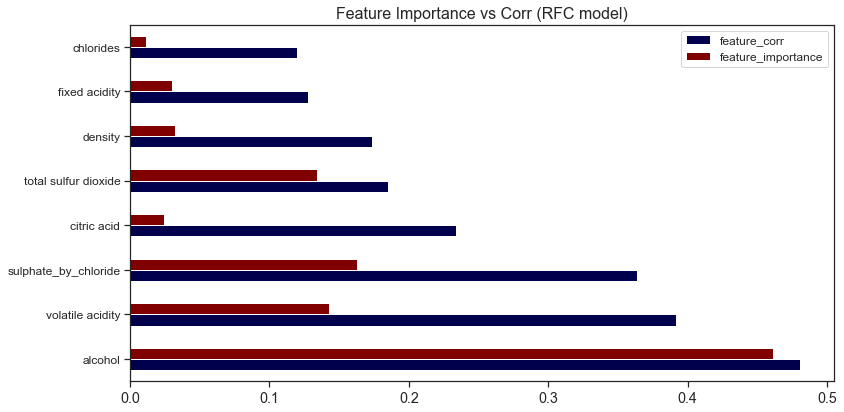

In [297]:
# Visualize feature correlations and importance

features_df_RFC.plot(kind="barh", legend=True, label=True, figsize=(12,6), colormap=seismic)
plt.legend(bbox_to_anchor=(1, 1), fontsize=12)
plt.title("Feature Importance vs Corr (RFC model)", fontsize=16)
plt.yticks(fontsize=12)
plt.tight_layout()
# plt.savefig("importance_vs_corr_RFC.png", dpi=400)

It appears that unlike the SVC algo, feature importance of the RFC has a strong association with the feature correlations with the target

#### 7.1 Fine tune ExtraTreesClassifier (ETC)

In [298]:
 
max_depth = [8] # The lower the higher regularization 
# n_estimators = [50,100,150]
max_features = [2,4,6] # The lower the higher regularization 
min_samples_leaf = [8] # [2, 6, 12, 20] The higher the higher the regularization

param_grid = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf, max_features=max_features)

model = ExtraTreesClassifier()
SKF = StratifiedKFold(n_splits=12, random_state=10)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="f1_micro", cv=SKF)
grid_result = grid.fit(X_train_rescaled, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.613648 using {'max_depth': 8, 'max_features': 6, 'min_samples_leaf': 8}
0.585398 (0.042923) with: {'max_depth': 8, 'max_features': 2, 'min_samples_leaf': 8}
0.598748 (0.031471) with: {'max_depth': 8, 'max_features': 4, 'min_samples_leaf': 8}
0.613648 (0.040411) with: {'max_depth': 8, 'max_features': 6, 'min_samples_leaf': 8}


In [299]:
ETC =  ExtraTreesClassifier(max_depth=10, max_features=8, min_samples_leaf=3)
ETC.fit(X_train_rescaled, y_train)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=10, max_features=8,
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=3, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

#### 7.2 Evaluating ETC

In [300]:
ETC.score(X_train_rescaled,y_train)

0.8495297805642633

In [301]:
ETC.score(X_test_rescaled,y_test)

0.675

In [302]:
y_preds = ETC.predict(X_test_rescaled)
print("=====================\nF1_score:\n")
print(m.f1_score(y_test, y_preds, average='micro'))
print("=====================\nConfusion Matrix:\n")
print(m.confusion_matrix(y_test, y_preds))
print("\n=================\nClassification Report:\n")
print(m.classification_report(y_test, y_preds))

F1_score:

0.675
Confusion Matrix:

[[  0   0   1   1   0   0]
 [  0   0   3   3   0   0]
 [  0   0 108  38   2   0]
 [  0   0  32  86   7   0]
 [  0   0   1  12  22   0]
 [  0   0   0   3   1   0]]

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         6
           2       0.74      0.73      0.74       148
           3       0.60      0.69      0.64       125
           4       0.69      0.63      0.66        35
           5       0.00      0.00      0.00         4

    accuracy                           0.68       320
   macro avg       0.34      0.34      0.34       320
weighted avg       0.65      0.68      0.66       320



#### 8.1 Fine tune XGB Classifier

In [304]:
max_depth = [8] # ,4,8,16]
learning_rate = [0.05] # 0.03, 0.05
min_child_weight = [1, 2, 11]

param_grid = dict(max_depth=max_depth, learning_rate=learning_rate, min_child_weight=min_child_weight)

model = xgb.XGBClassifier()
SKF = StratifiedKFold(n_splits=12, random_state=10)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring="f1_micro", cv=SKF)
grid_result = grid.fit(X_train_rescaled, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.654492 using {'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 1}
0.654492 (0.048773) with: {'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 1}
0.638012 (0.039646) with: {'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 2}
0.641884 (0.039912) with: {'learning_rate': 0.05, 'max_depth': 8, 'min_child_weight': 11}


In [383]:
xgboost = xgb.XGBClassifier(max_depth=4, learning_rate=0.045, min_child_weight=11)
xgboost.fit(X_train_rescaled,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.045, max_delta_step=0, max_depth=4,
              min_child_weight=11, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

#### 8.2 Evaluating XGB Classifier

In [384]:
xgboost.score(X_train_rescaled,y_train)

0.7170846394984326

In [385]:
xgboost.score(X_test_rescaled,y_test)

0.621875

In [386]:
y_preds = xgboost.predict(X_test_rescaled)
print("=====================\nF1_score:\n")
print(m.f1_score(y_test, y_preds, average='micro'))
print("=====================\nConfusion Matrix:\n")
print(m.confusion_matrix(y_test, y_preds))
print("\n=================\nClassification Report:\n")
print(m.classification_report(y_test, y_preds))

F1_score:

0.621875
Confusion Matrix:

[[  0   0   2   0   0   0]
 [  0   0   3   3   0   0]
 [  0   0 104  43   1   0]
 [  0   0  35  81   9   0]
 [  0   0   0  21  14   0]
 [  0   0   0   2   2   0]]

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         6
           2       0.72      0.70      0.71       148
           3       0.54      0.65      0.59       125
           4       0.54      0.40      0.46        35
           5       0.00      0.00      0.00         4

    accuracy                           0.62       320
   macro avg       0.30      0.29      0.29       320
weighted avg       0.60      0.62      0.61       320



#### 9 Ensemble model based on SVC, RFC and ETC using voting classifier

In [387]:
voting_clf = VotingClassifier(
estimators=[('rfc', RFC), ('svc', SVC_rbf),("etc", ETC), ("xgbc", xgboost)],
voting='soft')
voting_clf.fit(X_train_rescaled, y_train)

VotingClassifier(estimators=[('rfc',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=3,
                                                     max_features=4,
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=3,
                                                     min_samples_split=2,
                                                     min_weight_fraction_leaf=0.0,
               

##### Evaluation performance

In [388]:
voting_clf.score(X_train_rescaled,y_train)

0.7155172413793104

In [389]:
voting_clf.score(X_test_rescaled,y_test)

0.625

In [390]:
[estimator.score(X_test_rescaled, y_test) for estimator in voting_clf.estimators_]

[0.603125, 0.6125, 0.66875, 0.621875]

In [391]:
[estimator.score(X_train_rescaled, y_train) for estimator in voting_clf.estimators_]

[0.6136363636363636, 0.658307210031348, 0.8495297805642633, 0.7170846394984326]

In [392]:
y_preds = voting_clf.predict(X_test_rescaled)
print("=====================\nF1_score:\n")
print(m.f1_score(y_test, y_preds, average='micro'))
print("=====================\nAccuracy Score:\n")
print(m.accuracy_score(y_test, y_preds))
print("=====================\nConfusion Matrix:\n")
print(m.confusion_matrix(y_test, y_preds))
print("\n=================\nClassification Report:\n")
print(m.classification_report(y_test, y_preds))

F1_score:

0.625
Accuracy Score:

0.625
Confusion Matrix:

[[  0   0   2   0   0   0]
 [  0   0   4   2   0   0]
 [  0   0 107  40   1   0]
 [  0   0  35  82   8   0]
 [  0   0   0  24  11   0]
 [  0   0   0   3   1   0]]

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         6
           2       0.72      0.72      0.72       148
           3       0.54      0.66      0.59       125
           4       0.52      0.31      0.39        35
           5       0.00      0.00      0.00         4

    accuracy                           0.62       320
   macro avg       0.30      0.28      0.29       320
weighted avg       0.60      0.62      0.61       320



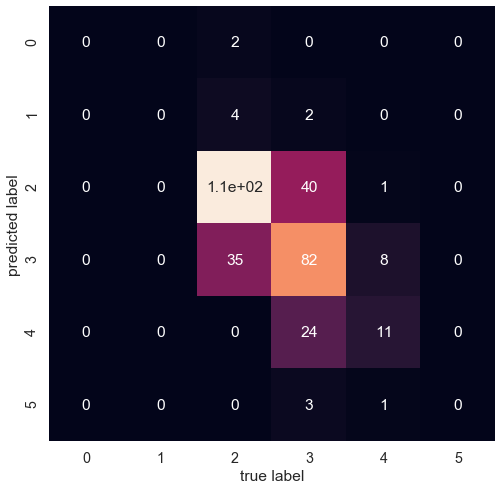

In [393]:
sns.set(font_scale=1.3) # Increase font size

def plot_conf_mat(y_test, y_preds):
    """
    Plots a confusion matrix using Seaborn's heatmap().
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),
                     annot=True, # Annotate the boxes
                     cbar=False)
    plt.xlabel("true label")
    plt.ylabel("predicted label")
#     plt.savefig("corr_mat.png", dpi=300)
    plt.show()
    
plot_conf_mat(y_test, y_preds)


We can also use matshow plot to represent the results from the correlation matrix

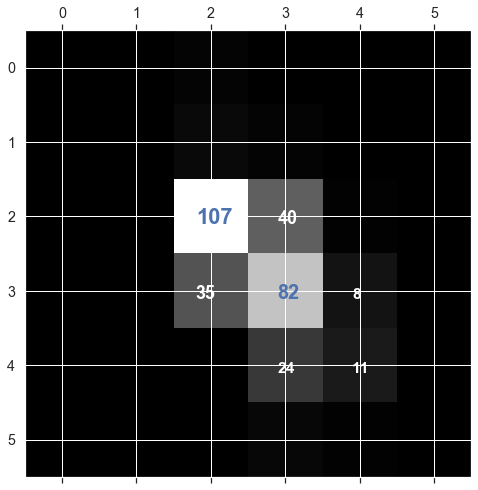

In [394]:
plt.rcParams["figure.figsize"] = (8,8)
conf_mx = m.confusion_matrix(y_test, y_preds)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.annotate("107",(1.8,2.1), color="b", weight='bold', fontsize=22)
plt.annotate("40",(2.9,2.1), color="w", weight='bold',fontsize=18)
plt.annotate("35",(1.8,3.1), color="w", weight='bold',fontsize=18)
plt.annotate("82",(2.9,3.1), color="b", weight='bold',fontsize=20)
plt.annotate("8",(3.9,3.1), color="w", weight='bold')
plt.annotate("11",(3.9,4.1), color="w", weight='bold')
plt.annotate("24",(2.9,4.1), color="w", weight='bold')
# plt.savefig("matshow.png", dpi=300)
plt.show()


**Highlighting the errors** produced by the model: We need to divide each value in the confusion matrix by the number of wines in the corresponding class, so you can compare error rates instead of absolute number of errors (which would make abundant classes look unfairly bad). We perform the normalization and plot the results again.

Text(44.5, 0.5, 'predicted label')

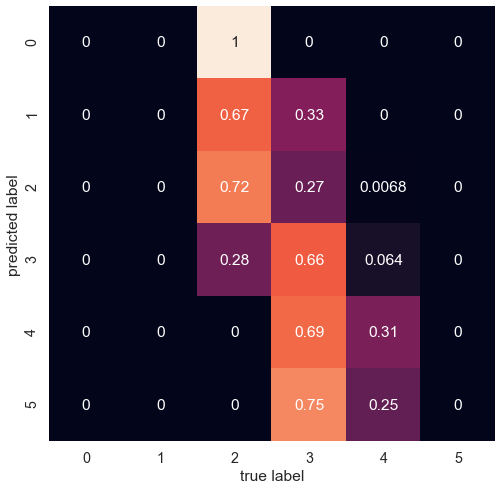

In [395]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(norm_conf_mx,
                     annot=True, # Annotate the boxes
                     cbar=False)
plt.xlabel("true label")
plt.ylabel("predicted label")

This diagram shows us that the classess 2 and 3 are the ones that are being missclassified the most.

We see that we hit a 64% of predictions correcly, and as we can appreciate in the confusion matrix, most of errors fall by one point of quality(+-1), meaning that we can make good use of our model to estimate the quality of red wine.
We also observe more false negatives (below the diagonal) than false positives (above the diagonal) meaning that our **precision** is better than our **recall**. Or in other words, our model is more **specific** than **sensitive**.

ROC Curve (plot of true positive rate versus false positive rate) and AUC (Area Under Curve) Scores¶
[see](https://stackoverflow.com/questions/45332410/sklearn-roc-for-multiclass-classification)

We have to convert your problem into binary by using OneVsAll approach, so we will end-up with n_class number of ROC curves

In [396]:
y_test = label_binarize(y_test, classes=[0,1,2,3,4,5])
n_classes = 6

In [397]:
y_score = voting_clf.fit(X_train_rescaled, y_train).predict_proba(X_test_rescaled) # for SVC we would have to use decision_function instead of predict_proba

In [398]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

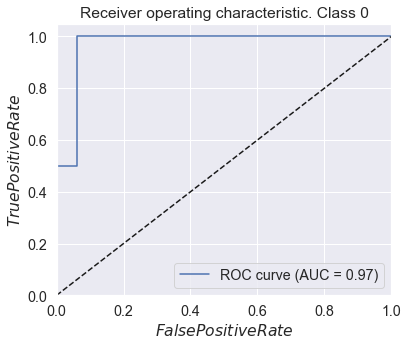

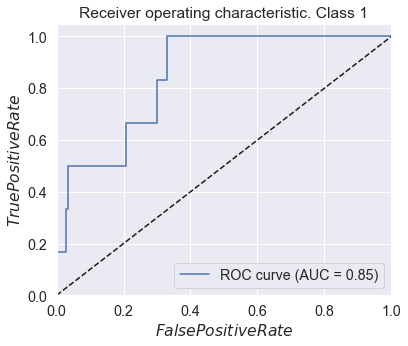

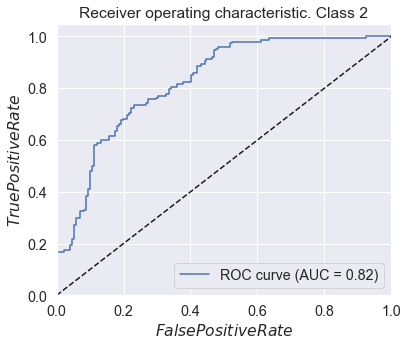

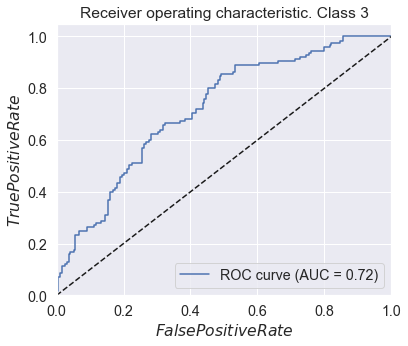

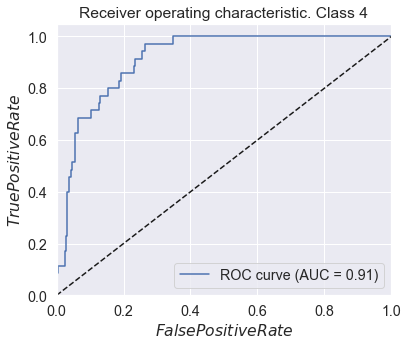

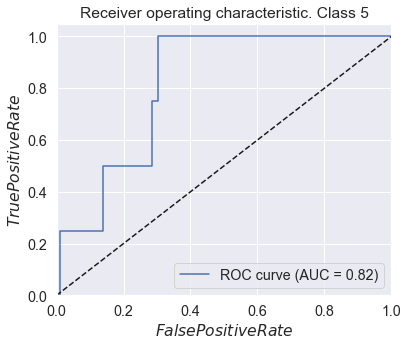

In [399]:
# Plot of a ROC curve for a specific class
plt.rcParams["figure.figsize"] = (6,5)
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (AUC = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('$False Positive Rate$') # We can use $ to make the font italic
    plt.ylabel('$True Positive Rate$')
    plt.title('Receiver operating characteristic. Class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()

We can observe that we have good room for improvement predicting the classes 2 and 3. It appears that the model produced struggles more with the middle values, which was to be be expected

### 10. Stacking Ensemble

I will also explore the stacking ensemble approach. For this the following steps need to be followed:
* Split train set into 2 subsets.
* Train the estimators using training subset 1.
* We predict the subset 2 using the trained models.
* Based on the predictions, we generate another training X set (held_out) that we use to train out blender model

In [400]:
#1) 

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, random_state=42)

#2)
SVC_rbf = SVC(kernel="rbf", C=1.5, gamma=0.1, tol=0.001, probability=True)
RFC =  RandomForestClassifier(max_depth=3, max_features=4, min_samples_leaf=3)
ETC =  ExtraTreesClassifier(max_depth=10, max_features=8, min_samples_leaf=3)
xgboost = xgb.XGBClassifier(max_depth=2)

blender = RandomForestClassifier(random_state=42)

for p in [SVC_rbf, RFC, ETC,xgboost]:
    p.fit(X_train_1, y_train_1)
    
#3)    
SVC_rbf_p = SVC_rbf.predict(X_train_2)
RFC_p = RFC.predict(X_train_2)
ETC_p = ETC.predict(X_train_2)
xgboost_p = xgboost.predict(X_train_2)

#4)
held_out = np.column_stack((SVC_rbf_p, RFC_p, ETC_p, xgboost_p)) 
blender.fit(held_out, y_train_2)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [401]:
result_1 = []
for p in [SVC_rbf, RFC, ETC, xgboost]:
    result_1.append(p.predict(X_test)) 
    
    """To check the model performance against the test set we need to obtain a prediction 
    test obtained from stacking the predictions from each estimator"""

y_pred_s = blender.predict(np.column_stack(tuple(result_1)))
accuracy_score(y_test, y_pred_s)

0.6165413533834586

In [402]:
result_2 = []
for p in [SVC_rbf, RFC, ETC, xgboost]:
    result_2.append(p.predict(X_train))

y_pred_s = blender.predict(np.column_stack(tuple(result_2)))
accuracy_score(y_train, y_pred_s)

0.7936507936507936

With the stacking ensemble approach we obtained a blender that performed worse than using Voting Classifier.

#### Future directions

How can we improve the model? 
* **Gather more training data**. In particular for the classes 2 and 3
* Include features that are more specific for these classess
* Since classess 2 and 3 are not being satisfactorialy separated by our algo, we could consider grouping them both into one "middle quality" category